In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/doubanmovieshortcomments/DMSC.csv


In [31]:
import csv
import jieba
import pickle

# 文本预处理
# with open('/kaggle/input/doubanmovieshortcomments/DMSC.csv','r') as f:
#     reader = csv.DictReader(f)
#     data = [(jieba.lcut(row['Comment']), int(row['Star']) < 3)
#                      for row in reader if row['Star'] != '3']

# 保存
# with open('comments.pkl', 'wb') as f:
#     pickle.dump(data, f)

# 保存sentencepiece输入
# with open('/kaggle/input/doubanmovieshortcomments/DMSC.csv','r') as f:
#     reader = csv.DictReader(f)
#     with open('scp_input.txt', 'w') as f:
#         for row in reader: f.write(row['Comment'])

In [32]:
import sentencepiece as spm

# 引入外部文本资料训练分词模型
spm.SentencePieceTrainer.Train(input='scp_input.txt', 
                               model_prefix='scp_output',
                               vocab_size=10000) # Train the model

# 加载模型进行分词
sp = spm.SentencePieceProcessor(model_file='scp_output.model')
# 测试分词
print(sp.EncodeAsPieces('以为主题深刻，实则老调重弹')) # 分词

['▁', '以为', '主题', '深刻', ',', '实', '则', '老', '调', '重', '弹']


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: scp_input.txt
  input_format: 
  model_prefix: scp_output
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  d

In [33]:
import pickle

with open('comments.pkl','rb') as f:
    data = pickle.load(f)

([' ', '2015', '年度', '最', '失望', '作品', '。', '以为', '面面俱到', '，', '实则', '画蛇添足', '；', '以为', '主题深刻', '，', '实则', '老调重弹', '；', '以为', '推陈出新', '，', '实则', '俗不可耐', '；', '以为', '场面', '很', 'high', '，', '实则', 'high', '劲', '不足', '。', '气', '！', '上', '一集', '的', '趣味', '全无', '，', '这集', '的', '笑', '点', '明显', '刻意', '到', '心虚', '。', '全片', '没有', '任何', '片段', '给', '我', '有', '紧张', '激动', '的', '时候', '，', '太弱', '了', '，', '跟', '奥创', '一样', '。'], True)
1650497


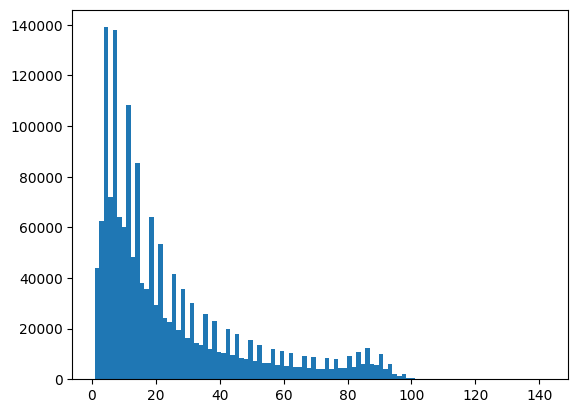

In [34]:
import matplotlib.pyplot as plt

print(data[1])
print(len(data))
plt.hist([len(c)  for c,_  in data], bins=100)
plt.show()

In [35]:
# 词汇表
vocab = set()
for c,_ in data[:10000]: vocab.update(c)
tokenIdx = { token:idx+1 for idx,token in enumerate(vocab)}     
tokenIdx.update({'PAD': 0, 'UNK': -1})
tokenIdx['PAD'],tokenIdx['UNK'],len(tokenIdx)

(0, -1, 18909)

In [36]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def collateData(batch_data):
    comments = []
    labels = []
    for comment,s in batch_data:
        comments.append(torch.tensor([tokenIdx.get(c, -1) for c in comment]))
        labels.append(1 if s else 0)
    comments = pad_sequence(comments, batch_first=True)
    labels = torch.tensor(labels)
    return comments, labels

dl = DataLoader(data[:10000], batch_size=4,shuffle=True,collate_fn=collateData)

cpu


In [37]:
class MyClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_size,batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, input):
        output = self.embedding(input)
        output,_ = self.rnn(output)
        output = self.fc(output[:,-1,:])
        return output

In [38]:
from tqdm import tqdm

model = MyClassifier(len(tokenIdx), 100, 128, 2)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoches = range(10)
bar = tqdm(epoches)
for epoch in bar:
    for comments, labels in dl:
        output = model(comments.to(device))
        loss = criterion(output, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    bar.set_description(f'loss {loss.item():.5f}')

loss 0.06290: 100%|██████████| 10/10 [09:01<00:00, 54.14s/it]


In [39]:
model.eval()

def predict(comment):
    input = torch.tensor([tokenIdx.get(c, -1) for c in jieba.lcut(comment)])
    input = input.unsqueeze(0).to(device)
    output = model(input)
    label_hat = torch.argmax(output, dim = 1).item()
    print(output,label_hat)

predict('OK')

for c in ('不值','难看','好看','不好看'): predict(c)

tensor([[ 0.3833, -0.4108]], grad_fn=<AddmmBackward0>) 0
tensor([[-0.9971,  1.2285]], grad_fn=<AddmmBackward0>) 1
tensor([[-1.2883,  1.5065]], grad_fn=<AddmmBackward0>) 1
tensor([[ 1.1495, -1.2288]], grad_fn=<AddmmBackward0>) 0
tensor([[0.2170, 0.2090]], grad_fn=<AddmmBackward0>) 0
